# Sentiment Analysis for Financial News

In [1]:
import pandas as pd
import numpy as np

# graphs
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
sns.set_context("paper")

# cleaning
import unidecode

# stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# vocab
from collections import Counter

# models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm  


[nltk_data] Downloading package stopwords to C:\Users\Camille
[nltk_data]     Leempoels\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Camille Leempoels\.conda\envs\finance\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Preprocessing

Loading the dataset.

In [3]:
data = pd.read_csv('data.csv', encoding='latin-1', names=['sentiment','text'])

In [4]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


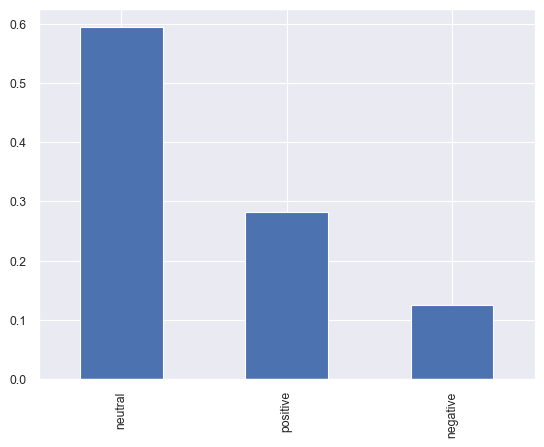

In [5]:
(data.sentiment.value_counts() / data.shape[0]).plot.bar();

Cleaning the text.

In [6]:
# Removing punctuation and special caracters
data['text'] = data['text'].str.replace('[^\w\s]', '', regex=True)
data['text'] = data['text'].str.replace('_', ' ')
data['text'] = data['text'].astype('unicode')
data['text'] = data['text'].transform(lambda x: unidecode.unidecode(x))

# Lowercase the text
data['text'] = data['text'].str.lower()

# Removing numbers
data['text'] = data['text'].str.replace('\d+', '', regex=True)

# Removing stop words
nltk_stopwords = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: [item for item in x.split() if item not in nltk_stopwords])

# Lemmatization and/or Expand Contractions ?

Split train and test set

In [60]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=1)
test_set, validation_set = train_test_split(test_set, test_size=0.5, random_state=2)

Building the vocabulary from the training set

In [255]:
# extract all the words and count them
vocab = Counter([word for sentence in train_set['text'].values.tolist() for word in sentence])

print('Number of words in the training set : ' + str(sum(vocab.values())))
print('Number of unique words in the training set : ' + str(len(list(vocab))))

# Sort the words
vocab = vocab.most_common()

print('Most frequent words : ' + str(vocab[0:10]))

# convert the vocabulary to a Python Dict
vocab = dict(vocab)

# encode words as integers
sparse_vocab = {word:i for i, word in enumerate(vocab, 1)} 
inv_sparse_vocab = {v: k for k, v in sparse_vocab.items()}

unknown = len(list(vocab)) + 1

Number of words in the training set : 46400
Number of unique words in the training set : 8337
Most frequent words : [('eur', 1057), ('company', 680), ('mn', 475), ('said', 437), ('finnish', 405), ('sales', 354), ('million', 335), ('profit', 325), ('net', 323), ('finland', 278)]


Distribution of the length of the sentences

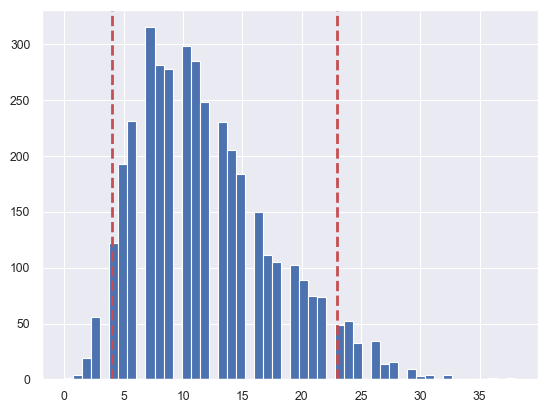

In [256]:
length = train_set['text'].apply(lambda sentence : len(sentence))
limit_low, limit_high  = length.quantile(q=[0.05, 0.95]).values
length.hist(bins=50);
plt.axvline(limit_low, color='r', linewidth=2, linestyle="dashed");
plt.axvline(limit_high, color='r', linewidth=2, linestyle="dashed");

Encode the text and labels

In [257]:
def encode_text(data, limit_low = limit_low, limit_high = limit_high):
    # encode sentences and set -1 if the word is not in the vocabulary
    data['text_encoded'] = data['text'].apply(
        lambda sentence : [sparse_vocab.get(word, unknown) for word in sentence]
    )

    # drop sentences that are extremely short or long
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))
    data = data[(data['length'] <= limit_high) & (data['length'] >= limit_low)].copy()

    # pad sentences so that each vector has the same length
    max_len = int(limit_high)
    data['text_encoded'] = data.apply(lambda row: [0] * (max_len - row['length']) + row['text_encoded'], axis=1)
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))

    if sum(data['length'] != max_len):
        print('WARNING')

    return data

def decode(data):
    for encoded_sentence in data:
        print([inv_sparse_vocab.get(number, '') for number in encoded_sentence])

Store the encoded data as Tensors.

In [258]:
def format_tensors(set):
    txt = encode_text(set.copy())
    labels = txt['sentiment'].replace(['positive','neutral','negative'], [0, 1, 2])

    return torch.tensor(np.vstack(txt['text_encoded'])), torch.tensor(np.vstack(labels)).long()#.to(device)

train_txt, train_labels = format_tensors(train_set)
val_txt, val_labels = format_tensors(validation_set)
test_txt, test_labels = format_tensors(test_set)

validation_dataloader = DataLoader(
    TensorDataset(val_txt, val_labels), 
    batch_size = len(val_labels)
)

test_dataloader = DataLoader(
    TensorDataset(test_txt, test_labels), 
    batch_size = len(test_labels)
)

## Supervised learning

### A first naive model

Initialize a RNN module with Pytorch.

In [312]:
class RNN_module(nn.Module):

    def __init__(self, vocab_dim, embedding_dim, hidden_dim):
        super().__init__()

        # embedding layer
        self.embedding_layer = nn.Embedding(vocab_dim, embedding_dim, padding_idx=0)
        # RNN layer
        self.rnn_layer = nn.RNN(embedding_dim, hidden_dim)
        # fully connected layer
        self.fc_layer = nn.Linear(hidden_dim, 3)

    def forward(self, txt):
        emb_txt = self.embedding_layer(txt.T)
        rnn_out, rnn_hidden = self.rnn_layer(emb_txt)
        fc_out = self.fc_layer(rnn_hidden.squeeze(0))
        return fc_out

Wrap the RNN module with Skorch.

In [13]:
from skorch import NeuralNetClassifier

rnn_net = NeuralNetClassifier(
    RNN_module,
    criterion = nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    device = 'cuda',
    module__vocab_dim = len(vocab) + 2,
    module__embedding_dim = 50,
    module__hidden_dim = 32
)

Finetune the hyperparameters with GridSearch

In [43]:
param_grid = {
    'batch_size' : [16, 32],
    'max_epochs' : [10, 50, 100],
    'lr' : [1e-2, 1e-3],
    'module__embedding_dim' : [10, 50, 100],
    'module__hidden_dim' : [10, 50, 100]
}

grid = GridSearchCV(
    estimator=rnn_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=10
)

# cv_res = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res.best_score_, cv_res.best_params_))
# print(cv_res.best_estimator_)
# pd.DataFrame(cv_res.cv_results_).to_csv('cv_res.csv', index = False)
cv_res_df = pd.read_csv('cv_res.csv')

Best: 0.625667 using {'batch_size': 16, 'lr': 0.001, 'max_epochs': 50, 'module__embedding_dim': 50, 'module__hidden_dim': 100}
<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=RNN_module(
    (embedding): Embedding(8338, 50, padding_idx=0)
    (rnn): RNN(50, 100)
    (fc): Linear(in_features=100, out_features=3, bias=True)
  ),
)


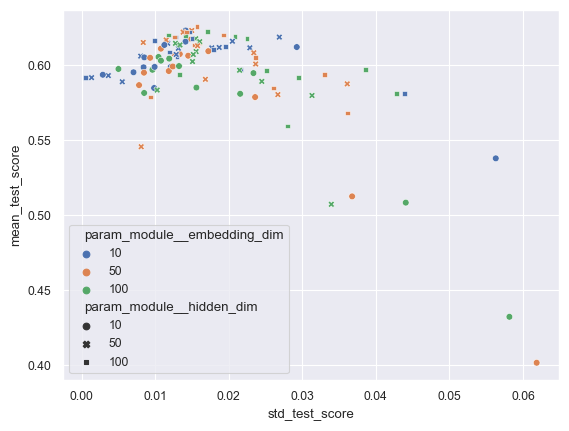

In [44]:
sns.scatterplot(
    data=cv_res_df, 
    y='mean_test_score', 
    x='std_test_score', 
    hue='param_module__embedding_dim', 
    style='param_module__hidden_dim', 
    palette="deep"
);

The gridsearch only looks at the best average test score, it doesn't take into account the standard deviation. By plotting the results, we can see that the parameters EMBEDDING_DIM = 50 and HIDDEN_DIM = 50 seem lead to a good compromise between mean and standard deviation.

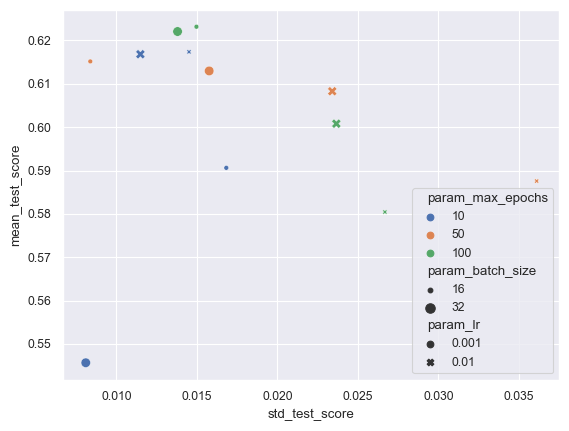

In [53]:
sns.scatterplot(
    data=cv_res_df.query('param_module__embedding_dim == 50 and param_module__hidden_dim == 50'), 
    y='mean_test_score', 
    x='std_test_score', 
    hue='param_max_epochs', 
    style='param_lr', 
    size='param_batch_size',
    palette="deep"
);

We will keep MAX_EPOCHS = 100, BATCH_SIZE = 32 and LR = 0.001.

Train and evaluate the model.

In [297]:
def train_epoch(dataloader, model, optimizer, loss_function):
    
    model.train()
    # h = model.init_hidden(16)
    
    for txt, label in dataloader:

        # txt, label = txt.to(device), label.to(device)

        # forward computation
        pred = model(txt)
        loss = loss_function(pred, label.squeeze())

        # backward computation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()

In [313]:
def eval_epoch(dataset, model, loss_function, accuracy_function):
    
    model.eval()
    # h = model.init_hidden(16)
    loss = []
    acc = []
    
    with torch.no_grad():

        for txt, label in dataset:

            # txt, label = txt.to(device), label.to(device)

            pred = model(txt)
            loss.append(loss_function(pred, label.squeeze()).item())
            acc.append(accuracy_function(pred, label).item())
        
    return np.mean(loss), np.mean(acc)

In [314]:
def train_and_validate_model(model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, verbose = False):
    
    train_dataloader = DataLoader(
        TensorDataset(train_txt, train_labels), 
        batch_size = BATCH_SIZE,
        shuffle = True
    )

    loss_function = nn.CrossEntropyLoss()
    accuracy_function = lambda pred, target : torch.sum((torch.argmax(torch.softmax(pred, dim=1), dim=1) == target.T)) / len(target)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    train_loss_array = []
    train_accuracy_array = []
    val_loss_array = []
    val_accuracy_array = []

    for epoch in tqdm(range(EPOCHS)):
        # training
        train_epoch(train_dataloader, model, optimizer, loss_function)

        # compute loss and accuracy metrics
        train_loss, train_accuracy = eval_epoch(train_dataloader, model, loss_function, accuracy_function)
        val_loss, val_accuracy = eval_epoch(validation_dataloader, model, loss_function, accuracy_function)

        train_loss_array.append(train_loss)
        train_accuracy_array.append(train_accuracy)
        val_loss_array.append(val_loss)
        val_accuracy_array.append(val_accuracy)

        if verbose:
            print('EPOCH : ' + str(epoch + 1))
            print('Training loss : ' + str(train_loss) + ' | Training accuracy : ' + str(train_accuracy))
            print('Validation loss : ' + str(val_loss) + ' | Validation accuracy : ' + str(val_accuracy))

    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout = True, figsize = (10,10))

    sns.lineplot(x=range(EPOCHS), y=train_loss_array, ax=ax1, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_loss_array, ax=ax1, label='Validation set')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Loss')
    ax1.legend();

    sns.lineplot(x=range(EPOCHS), y=train_accuracy_array, ax=ax2, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_accuracy_array, ax=ax2, label='Validation set')
    ax2.set_xlabel('Epochs')
    ax2.set_title('Accuracy')
    ax2.legend();

    fig.suptitle('RNN | Batch size : ' + str(BATCH_SIZE) + ' | Embedding : ' + str(EMBEDDING_DIM) + ' | Hidden : ' + str(HIDDEN_DIM) + ' | Rate : ' + str(LEARNING_RATE));

    return("Test set accuracy: %f" % eval_epoch(test_dataloader, model, loss_function, accuracy_function)[1])

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


'Test set accuracy: 0.627494'

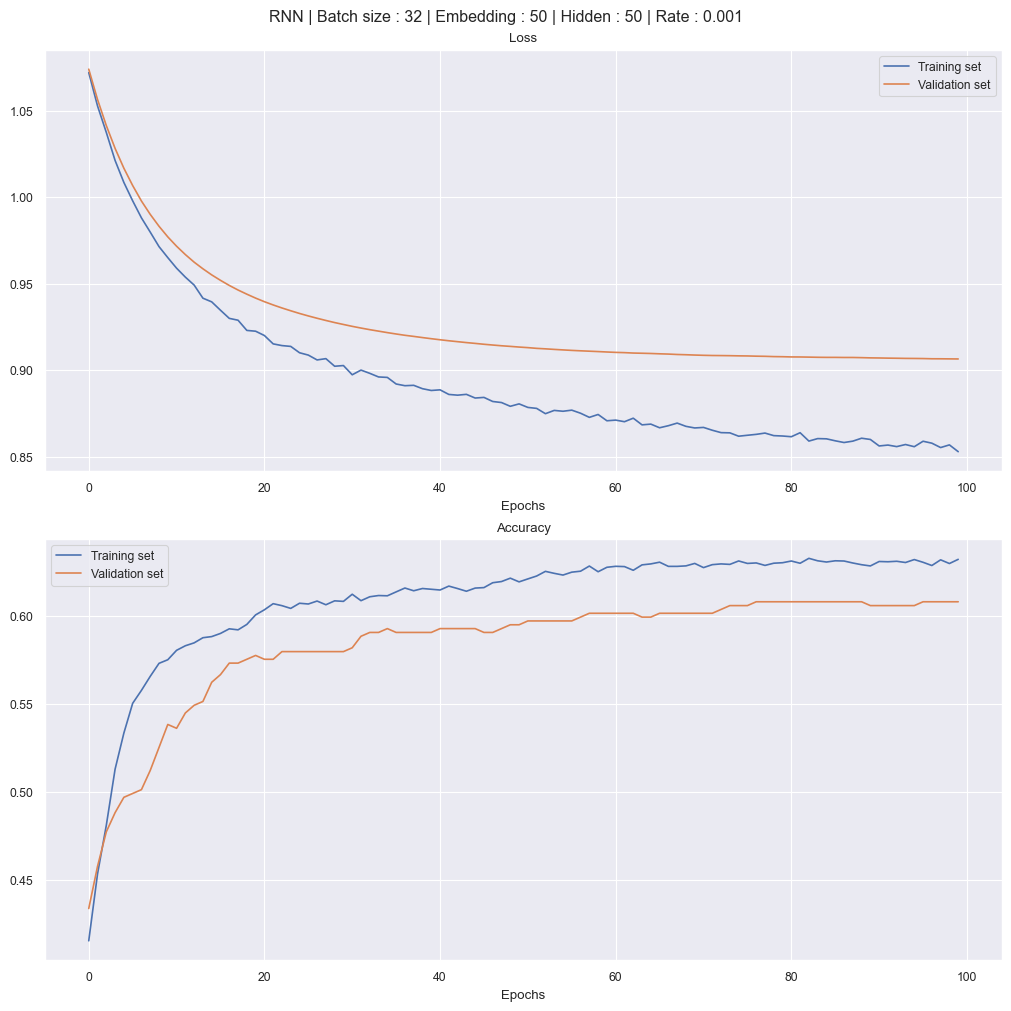

In [315]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM = 50
HIDDEN_DIM = 50
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 32

rnn_model = RNN_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM)

train_and_validate_model(rnn_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

Even with finetuned hyperparameters, the accuracy is low. We are trying a more sophisticated model in the next section.

### LSTM model

In [325]:
class LSTM_module(nn.Module):

    def __init__(self, vocab_dim, embedding_dim, hidden_dim, nb_lstm_layers, dropout):
        super().__init__()
        # hyperparameters
        self.vocab_dim = vocab_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.nb_lstm_layers = nb_lstm_layers
        self.dropout = dropout

        # embedding layer
        self.embedding_layer = nn.Embedding(
            self.vocab_dim, 
            self.embedding_dim, 
            padding_idx=0
            )

        # RNN layer
        self.lstm_layer=nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.hidden_dim,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
            dropout=self.dropout
        )

        # fully connected layer
        self.fc_layer = nn.Linear(self.hidden_dim, 3)

    def forward(self, txt):

        emb_txt = self.embedding_layer(txt)
        lstm_out, _ = self.lstm_layer(emb_txt)
        fc_out = self.fc_layer(lstm_out[:,-1,:])
        
        return fc_out

In [341]:
from skorch import NeuralNetClassifier

lstm_net = NeuralNetClassifier(
    LSTM_module,
    criterion = nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    device = 'cuda',
    module__vocab_dim = len(vocab) + 2,
    module__embedding_dim = 50,
    module__hidden_dim = 32,
    nb_lstm_layers = 2,
    dropout = 0.3
)

In [342]:
param_grid = {
    'batch_size' : [16, 32],
    'max_epochs' : [50],
    'lr' : [1e-1],
    'module__embedding_dim' : [20, 50, 100],
    'module__hidden_dim' : [20, 50, 100],
    'module__nb_lstm_layers' : [2],
    'module__dropout' : [0.1, 0.3, 0.5],
}

grid = GridSearchCV(
    estimator=lstm_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=10
)

cv_res_lstm = grid.fit(train_txt, train_labels.squeeze())
print("Best: %f using %s" % (cv_res_lstm.best_score_, cv_res_lstm.best_params_))
print(cv_res_lstm.best_estimator_)
pd.DataFrame(cv_res_lstm.cv_results_).to_csv('cv_res_lstm.csv', index = False)
# cv_res_df = pd.read_csv('cv_res.csv')

  2%|▏         | 1/50 [00:02<02:18,  2.82s/it]

EPOCH : 1
Training loss : 0.9271064644868153 | Training accuracy : 0.5916544298768569
Validation loss : 0.9471703767776489 | Validation accuracy : 0.5773420333862305


  4%|▍         | 2/50 [00:05<02:17,  2.86s/it]

EPOCH : 2
Training loss : 0.9180088272966477 | Training accuracy : 0.5914402839108186
Validation loss : 0.9430492520332336 | Validation accuracy : 0.5773420333862305


  6%|▌         | 3/50 [00:08<02:09,  2.77s/it]

EPOCH : 3
Training loss : 0.8836848951121259 | Training accuracy : 0.618850954566233
Validation loss : 0.9177411198616028 | Validation accuracy : 0.601307213306427


  8%|▊         | 4/50 [00:11<02:05,  2.72s/it]

EPOCH : 4
Training loss : 0.8681875530318541 | Training accuracy : 0.6206558982181128
Validation loss : 0.9082410335540771 | Validation accuracy : 0.6078431606292725


 10%|█         | 5/50 [00:13<02:02,  2.71s/it]

EPOCH : 5
Training loss : 0.8591349411115773 | Training accuracy : 0.6262236907093536
Validation loss : 0.9069057703018188 | Validation accuracy : 0.6143791079521179


 12%|█▏        | 6/50 [00:16<01:57,  2.68s/it]

EPOCH : 6
Training loss : 0.8531366660206329 | Training accuracy : 0.6290381792358365
Validation loss : 0.9068504571914673 | Validation accuracy : 0.6143791079521179


 14%|█▍        | 7/50 [00:19<01:56,  2.70s/it]

EPOCH : 7
Training loss : 0.8482979497983067 | Training accuracy : 0.6310266765728921
Validation loss : 0.9055151343345642 | Validation accuracy : 0.6122004389762878


 16%|█▌        | 8/50 [00:21<01:53,  2.71s/it]

EPOCH : 8
Training loss : 0.8427184996100774 | Training accuracy : 0.6321279981587952
Validation loss : 0.906615674495697 | Validation accuracy : 0.6165577173233032


 18%|█▊        | 9/50 [00:24<01:49,  2.67s/it]

EPOCH : 9
Training loss : 0.8350944496724049 | Training accuracy : 0.6414280470772462
Validation loss : 0.9023604989051819 | Validation accuracy : 0.6056644916534424


 20%|██        | 10/50 [00:27<01:47,  2.69s/it]

EPOCH : 10
Training loss : 0.838643072722767 | Training accuracy : 0.6454968184626575
Validation loss : 0.9055734872817993 | Validation accuracy : 0.6143791079521179


 22%|██▏       | 11/50 [00:29<01:45,  2.70s/it]

EPOCH : 11
Training loss : 0.8319467541142183 | Training accuracy : 0.6381852668812622
Validation loss : 0.9018643498420715 | Validation accuracy : 0.6100217700004578


 24%|██▍       | 12/50 [00:32<01:43,  2.71s/it]

EPOCH : 12
Training loss : 0.8195967171423235 | Training accuracy : 0.6486478219473415
Validation loss : 0.88998943567276 | Validation accuracy : 0.6122004389762878


 26%|██▌       | 13/50 [00:35<01:40,  2.72s/it]

EPOCH : 13
Training loss : 0.8101287629898424 | Training accuracy : 0.6506057268722467
Validation loss : 0.885010302066803 | Validation accuracy : 0.6165577173233032


 28%|██▊       | 14/50 [00:38<01:39,  2.77s/it]

EPOCH : 14
Training loss : 0.8106493722762306 | Training accuracy : 0.6472711699649626
Validation loss : 0.8900970220565796 | Validation accuracy : 0.6252723336219788


 30%|███       | 15/50 [00:41<01:40,  2.86s/it]

EPOCH : 15
Training loss : 0.799036942389568 | Training accuracy : 0.6633932942335826
Validation loss : 0.8766489028930664 | Validation accuracy : 0.6274510025978088


 32%|███▏      | 16/50 [00:43<01:35,  2.81s/it]

EPOCH : 16
Training loss : 0.7898549952170922 | Training accuracy : 0.6648311307776867
Validation loss : 0.8802103996276855 | Validation accuracy : 0.6209150552749634


 34%|███▍      | 17/50 [00:46<01:33,  2.82s/it]

EPOCH : 17
Training loss : 0.7812140616813945 | Training accuracy : 0.6750795400090155
Validation loss : 0.8744214773178101 | Validation accuracy : 0.6427015066146851


 36%|███▌      | 18/50 [00:49<01:28,  2.76s/it]

EPOCH : 18
Training loss : 0.7858412755480947 | Training accuracy : 0.6633932942335826
Validation loss : 0.8629363179206848 | Validation accuracy : 0.6448801755905151


 38%|███▊      | 19/50 [00:52<01:26,  2.78s/it]

EPOCH : 19
Training loss : 0.7721091578447872 | Training accuracy : 0.6732134116641225
Validation loss : 0.8594302535057068 | Validation accuracy : 0.6535947918891907


 40%|████      | 20/50 [00:55<01:23,  2.78s/it]

EPOCH : 20
Training loss : 0.7693708336825938 | Training accuracy : 0.6651676457358877
Validation loss : 0.8566277623176575 | Validation accuracy : 0.6339869499206543


 42%|████▏     | 21/50 [00:57<01:19,  2.75s/it]

EPOCH : 21
Training loss : 0.7528586236653348 | Training accuracy : 0.6870717083304989
Validation loss : 0.8517647385597229 | Validation accuracy : 0.6601307392120361


 44%|████▍     | 22/50 [01:00<01:17,  2.77s/it]

EPOCH : 22
Training loss : 0.9444080368012584 | Training accuracy : 0.5637236907093536
Validation loss : 1.0481115579605103 | Validation accuracy : 0.529411792755127


 46%|████▌     | 23/50 [01:03<01:16,  2.83s/it]

EPOCH : 23
Training loss : 0.7413671979032425 | Training accuracy : 0.6855420950750948
Validation loss : 0.8661651015281677 | Validation accuracy : 0.6623093485832214


 48%|████▊     | 24/50 [01:06<01:13,  2.81s/it]

EPOCH : 24
Training loss : 0.721832753409373 | Training accuracy : 0.7037139012424957
Validation loss : 0.8688196539878845 | Validation accuracy : 0.6470588445663452


 50%|█████     | 25/50 [01:10<01:23,  3.33s/it]

EPOCH : 25
Training loss : 0.7494980547134047 | Training accuracy : 0.686979931487911
Validation loss : 0.9005969166755676 | Validation accuracy : 0.6492374539375305


 52%|█████▏    | 26/50 [01:14<01:19,  3.33s/it]

EPOCH : 26
Training loss : 0.707286702903882 | Training accuracy : 0.7105359765926647
Validation loss : 0.8745996356010437 | Validation accuracy : 0.6623093485832214


 54%|█████▍    | 27/50 [01:18<01:24,  3.69s/it]

EPOCH : 27
Training loss : 0.6972278901396344 | Training accuracy : 0.7164096916299559
Validation loss : 0.8920523524284363 | Validation accuracy : 0.6339869499206543


 56%|█████▌    | 28/50 [01:21<01:14,  3.40s/it]

EPOCH : 28
Training loss : 0.706989434584647 | Training accuracy : 0.7041116006311341
Validation loss : 0.8832848072052002 | Validation accuracy : 0.6601307392120361


 58%|█████▊    | 29/50 [01:25<01:17,  3.67s/it]

EPOCH : 29
Training loss : 0.6862034784539681 | Training accuracy : 0.7176945669010347
Validation loss : 0.8883399963378906 | Validation accuracy : 0.657952070236206


 60%|██████    | 30/50 [01:30<01:20,  4.00s/it]

EPOCH : 30
Training loss : 0.6631283729874615 | Training accuracy : 0.7283100832401393
Validation loss : 0.8832724094390869 | Validation accuracy : 0.6230936646461487


 62%|██████▏   | 31/50 [01:33<01:09,  3.67s/it]

EPOCH : 31
Training loss : 0.6843106147344942 | Training accuracy : 0.7073543808271181
Validation loss : 0.8899455070495605 | Validation accuracy : 0.6514161229133606


 64%|██████▍   | 32/50 [01:36<01:00,  3.36s/it]

EPOCH : 32
Training loss : 0.6643183675106401 | Training accuracy : 0.7370594713656388
Validation loss : 0.9119206070899963 | Validation accuracy : 0.6165577173233032


 66%|██████▌   | 33/50 [01:38<00:54,  3.19s/it]

EPOCH : 33
Training loss : 0.6201881355388574 | Training accuracy : 0.7572809594318205
Validation loss : 0.8988444805145264 | Validation accuracy : 0.6427015066146851


 68%|██████▊   | 34/50 [01:41<00:48,  3.05s/it]

EPOCH : 34
Training loss : 0.6237061413636816 | Training accuracy : 0.7361417034649114
Validation loss : 0.8948999047279358 | Validation accuracy : 0.6535947918891907


 70%|███████   | 35/50 [01:44<00:44,  2.94s/it]

EPOCH : 35
Training loss : 0.6008514902402651 | Training accuracy : 0.7589941263724004
Validation loss : 0.9113990068435669 | Validation accuracy : 0.6448801755905151


 72%|███████▏  | 36/50 [01:46<00:40,  2.88s/it]

EPOCH : 36
Training loss : 0.8781543140369364 | Training accuracy : 0.6197381303173854
Validation loss : 0.9357013702392578 | Validation accuracy : 0.6100217700004578


 74%|███████▍  | 37/50 [01:49<00:36,  2.81s/it]

EPOCH : 37
Training loss : 0.6318957759682827 | Training accuracy : 0.7403328439737732
Validation loss : 0.8670850396156311 | Validation accuracy : 0.6470588445663452


 76%|███████▌  | 38/50 [01:52<00:33,  2.77s/it]

EPOCH : 38
Training loss : 0.5999368893286205 | Training accuracy : 0.7588411649680873
Validation loss : 0.898445188999176 | Validation accuracy : 0.6274510025978088


 78%|███████▊  | 39/50 [01:54<00:30,  2.74s/it]

EPOCH : 39
Training loss : 0.5800963793163257 | Training accuracy : 0.7689060206455282
Validation loss : 0.8987650275230408 | Validation accuracy : 0.6470588445663452


 80%|████████  | 40/50 [01:57<00:28,  2.82s/it]

EPOCH : 40
Training loss : 0.5519838795262811 | Training accuracy : 0.7861294665000512
Validation loss : 0.8923304080963135 | Validation accuracy : 0.6361655592918396


 82%|████████▏ | 41/50 [02:00<00:24,  2.77s/it]

EPOCH : 41
Training loss : 0.5640669665278842 | Training accuracy : 0.7686306902490524
Validation loss : 0.896698534488678 | Validation accuracy : 0.6448801755905151


 84%|████████▍ | 42/50 [02:03<00:21,  2.72s/it]

EPOCH : 42
Training loss : 0.5562902184835089 | Training accuracy : 0.7827337250310419
Validation loss : 0.9890955686569214 | Validation accuracy : 0.5925925970077515


 86%|████████▌ | 43/50 [02:05<00:18,  2.71s/it]

EPOCH : 43
Training loss : 0.558579031263154 | Training accuracy : 0.772087616279787
Validation loss : 0.9492021799087524 | Validation accuracy : 0.6535947918891907


 88%|████████▊ | 44/50 [02:08<00:16,  2.68s/it]

EPOCH : 44
Training loss : 0.4935982813525305 | Training accuracy : 0.8109703867445959
Validation loss : 0.9207903146743774 | Validation accuracy : 0.6339869499206543


 90%|█████████ | 45/50 [02:11<00:13,  2.77s/it]

EPOCH : 45
Training loss : 0.5004275080784827 | Training accuracy : 0.8169052863436124
Validation loss : 0.9649912118911743 | Validation accuracy : 0.6122004389762878


 92%|█████████▏| 46/50 [02:14<00:11,  2.79s/it]

EPOCH : 46
Training loss : 0.4671329545423323 | Training accuracy : 0.8282550171608442
Validation loss : 0.9238218665122986 | Validation accuracy : 0.6492374539375305


 94%|█████████▍| 47/50 [02:16<00:08,  2.74s/it]

EPOCH : 47
Training loss : 0.4558836823649343 | Training accuracy : 0.8372797356828194
Validation loss : 0.9427230954170227 | Validation accuracy : 0.6252723336219788


 96%|█████████▌| 48/50 [02:19<00:05,  2.74s/it]

EPOCH : 48
Training loss : 0.4376351947235641 | Training accuracy : 0.8379527655992214
Validation loss : 0.9843465685844421 | Validation accuracy : 0.6296296119689941


 98%|█████████▊| 49/50 [02:22<00:02,  2.72s/it]

EPOCH : 49
Training loss : 0.6562194349285264 | Training accuracy : 0.7353157122754841
Validation loss : 0.9623262882232666 | Validation accuracy : 0.6383442282676697


100%|██████████| 50/50 [02:24<00:00,  2.90s/it]

EPOCH : 50
Training loss : 0.4869069348741733 | Training accuracy : 0.7993453255308882
Validation loss : 0.9985392689704895 | Validation accuracy : 0.6274510025978088


'Test set accuracy: 0.658537'

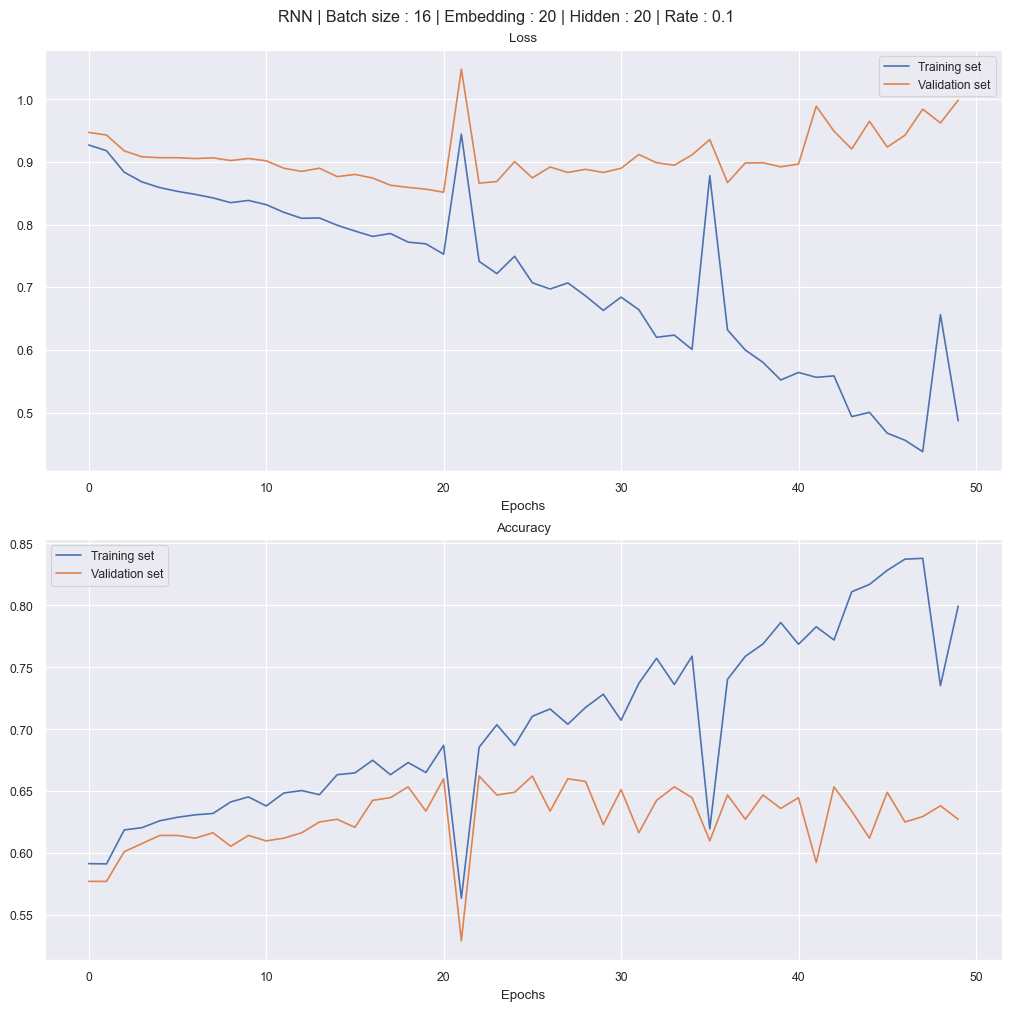

In [338]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =20
HIDDEN_DIM = 20
DROPOUT = 0.5
NB_LAYERS = 2

LEARNING_RATE = 1e-1
EPOCHS = 50
BATCH_SIZE = 16 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, verbose=True)